# import

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import ast
import seaborn as sns
import pandas as pd
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import wilcoxon, mannwhitneyu
import re
import scipy
from tqdm import tqdm 
import random
import ast
from pathlib import Path

def extract_errors_into_df(input_):

    correct = []
    error = []
    other = []

    for i in range (3):
        for e in range(3):
            if e == 0:
                correct = correct + [list(np.array(input_[i])[:,e])]
            if e == 1:
                error = error + [list(np.array(input_[i])[:,e])]
            if e == 2:
                other = other + [list(np.array(input_[i])[:,e])]


    errors = pd.DataFrame({ 'Group':['Early','Pre', 'Post'], 'correct':  correct, 
        'error': error, 'other': other })
    return errors 

def average_across_animals_transition_matrix(AA_transits):
    group_means = []
    for group in AA_transits:
        AA_data= []
        for animal in group:
            flat_list = [item for sublist in animal for item in sublist]
            normalised = list(np.array(flat_list) / max(flat_list))
            AA_data = AA_data + [normalised]
        concat_AA_data = conactinate_nth_items(AA_data)

        # recreate transition matrix: 
        means= [[]]*8
        count = 0
        index = 0
        for item in concat_AA_data:
            means[index] = means[index] + [np.mean(item)]
            count = count + 1
            if count == 4:
                count = 0
                index = index + 1

        group_means = group_means + [means]
    return(group_means)

def normalise_transition_matrix_means(group_means):
    normalised_means = []
    for e_type in group_means:

        transposed_data  = np.array(e_type).T.tolist()

        AA_data= []
        flat_list = []
        for s_port in transposed_data:
            normalised = list(np.array(s_port) / sum(s_port))
            flat_list = flat_list + normalised

            AA_data = AA_data + [flat_list]
        concat_AA_data = conactinate_nth_items(AA_data)

        # recreate transition matrix: 
        means= [[]]*4
        count = 0
        index = 0
        for item in concat_AA_data:
            means[index] = means[index] + [np.mean(item)]
            count = count + 1
            if count == 8:
                count = 0
                index = index + 1

        normalised_means = normalised_means + [np.array(means).T.tolist()]
        
    return normalised_means

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def parse_error_list(x):
    if isinstance(x, str):
        # extract all floats using regex
        nums = re.findall(r"[-+]?\d*\.\d+|\d+", x)
        return np.array([float(n) for n in nums])
    return x  # already an array/list

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth


def parse_training_levels(training_levels):
    t_levels = []
    for row in training_levels:
        row = row.replace('nan', 'None')
        row = '[' + ', '.join(convert_float_string(x) for x in row.strip('[]').split(', ')) + ']'
        t_levels.append(ast.literal_eval(row))
    return t_levels

def convert_float_string(s):
    try:
        # Attempt to convert scientific notation to a plain float string
        if 'e' in s.lower():
            value = float(s)
            return str(value)
        else:
            return s  # Return original string if not in scientific notation
    except ValueError:
        return s  # Return original string if not a valid float

def calculate_mean_std(t_levels, mask):
    """
    Selects the trial lists from t_levels using a boolean mask,
    concatenates nth items, and computes mean and std curves.
    Handles ragged input safely by avoiding NumPy masking.
    """
    # Safe boolean masking without NumPy
    selected = [t for t, m in zip(t_levels, mask) if m]
    # Combine the nth items from each selected trial list
    trial_scores = conactinate_nth_items(selected)
    # Compute mean and std across trials for each trial index
    mean_curve = [np.mean(scores) for scores in trial_scores]
    std_curve  = [np.std(scores)  for scores in trial_scores]

    return mean_curve, std_curve

def fill_between_mean_std(ax, mean_curve, std_curve, color,xlim):
    upper = np.array(mean_curve[:xlim]) + np.array(std_curve[:xlim])
    lower = np.array(mean_curve[:xlim]) - np.array(std_curve[:xlim])
    upper[upper > 50] = 50  # Ceiling effect cutoff
    ax.fill_between(range(len(upper)), lower, upper, alpha=0.2, edgecolor='None', facecolor=color, linewidth=1, linestyle='dashdot', antialiased=True)
    
def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth



In [ ]:
from Utilities.utils import *
# Get the current working directory
current_working_dir = os.path.join(Path(os.getcwd()).parent,'data') 
ed1_data_dict = load_h5(os.path.join(current_working_dir,r"ED1_data.h5"))
# convert data types to python friendly formats
ed1_data_dict = convert_loaded_data(ed1_data_dict)

# figure D (& L)

In [232]:
# load data
pl_data = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f1\DLS_DMS_lesion_learning_curves.csv")
pl_data['training_levels'] = pl_data['training_levels'].apply(ast.literal_eval)

# cut trials down:
cut = 4000

DLS_mask = pl_data.type.values =='DLS'

## DLS
catagories = pl_data.catagory[DLS_mask].values
animals = pl_data.animal[DLS_mask].values
t_levels = pl_data.training_levels[DLS_mask].values
lesion_mask = catagories == 'lesion'
control_mask = catagories == 'control'

dls_c_max_l = []
dls_c_t_reached = []
for item in t_levels[control_mask]:
    dls_c_max_l = dls_c_max_l+ [max(item[0:cut])]
    dls_c_t_reached = dls_c_t_reached + [np.where(np.array(item) == max(item[0:cut]))[0][0]]
    
dls_l_max_l = []
dls_l_t_reached = []
for item in t_levels[lesion_mask]:
    dls_l_max_l = dls_l_max_l+ [max(item[0:cut])]
    dls_l_t_reached = dls_l_t_reached + [np.where(np.array(item) == max(item[0:cut]))[0][0]]

DMS_mask = pl_data.type.values =='DMS'

## DMS
catagories = pl_data.catagory[DMS_mask].values
animals = pl_data.animal[DMS_mask].values
t_levels = pl_data.training_levels[DMS_mask].values
lesion_mask = catagories == 'lesion'
control_mask = catagories == 'control'

dms_c_max_l = []
dms_c_t_reached = []
for item in t_levels[control_mask]:
    dms_c_max_l = dms_c_max_l+ [max(item[0:cut])]
    dms_c_t_reached = dms_c_t_reached + [np.where(np.array(item) == max(item[0:cut]))[0][0]]
    
dms_l_max_l = []
dms_l_t_reached = []
for item in t_levels[lesion_mask]:
    dms_l_max_l = dms_l_max_l+ [max(item[0:cut])]
    dms_l_t_reached = dms_l_t_reached + [np.where(np.array(item) == max(item[0:cut]))[0][0]]
    



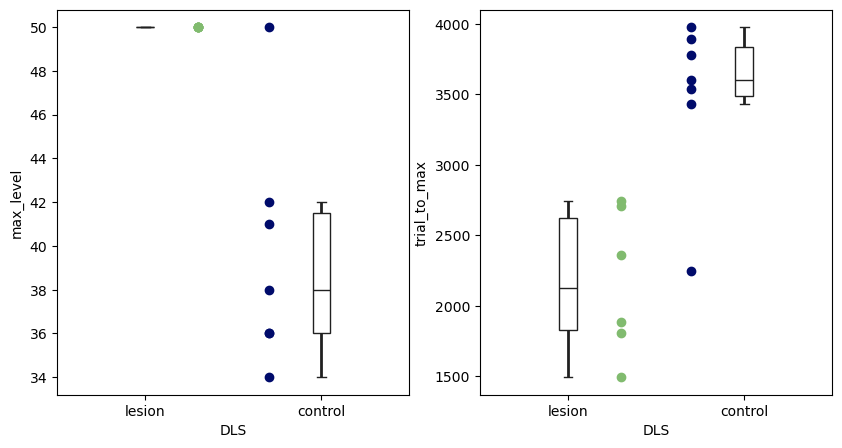

In [252]:
fig,[ax,ax1] = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot([0.3]*len(dls_c_t_reached), dls_c_t_reached,'o',color = '#81BB6F')
ax1.plot([0.7]*len(dls_l_t_reached), dls_l_t_reached,'o',color = '#000B6B')
plot_df = pd.DataFrame({'DLS': ['lesion']*len(dls_c_t_reached) + ['control']*len(dls_l_t_reached),'trial_to_max': dls_c_t_reached+dls_l_t_reached})
ax1=sns.boxplot( y = 'trial_to_max', x = 'DLS', data = plot_df, color = "#000B6B", width = .1, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax1)

ax.plot([0.3]*len(dls_c_max_l), dls_c_max_l,'o',color = '#81BB6F')
ax.plot([0.7]*len(dls_l_max_l), dls_l_max_l,'o',color = '#000B6B')
plot_df1 = pd.DataFrame({'DLS': ['lesion']*len(dls_c_max_l) + ['control']*len(dls_l_max_l),'max_level': dls_c_max_l+dls_l_max_l})
ax=sns.boxplot( y = 'max_level', x = 'DLS', data = plot_df1, color = "#000B6B", width = .1, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)


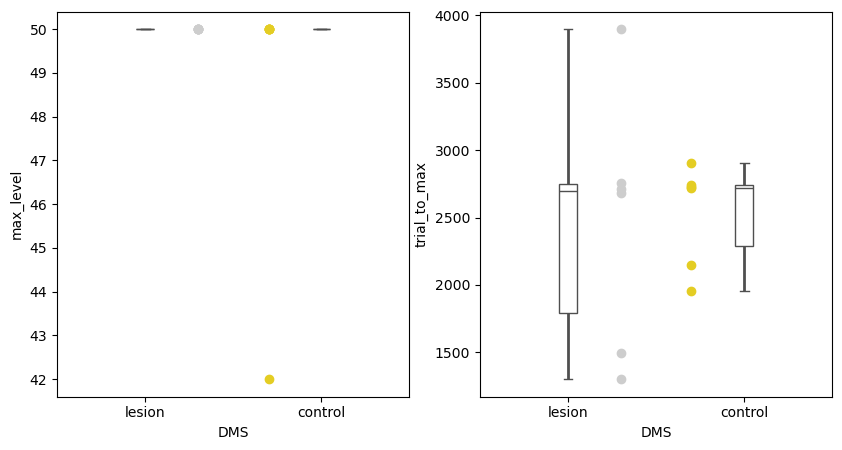

In [253]:
fig,[ax,ax1] = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot([0.3]*len(dms_c_t_reached), dms_c_t_reached,'o',color = "#CDCDCD")
ax1.plot([0.7]*len(dms_l_t_reached), dms_l_t_reached,'o',color = "#E4CD23")
plot_df2 = pd.DataFrame({'DMS': ['lesion']*len(dms_c_t_reached) + ['control']*len(dms_l_t_reached),'trial_to_max': dms_c_t_reached+dms_l_t_reached})
ax1=sns.boxplot( y = 'trial_to_max', x = 'DMS', data = plot_df2, color = "#E4CD23", width = .1, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax1)

ax.plot([0.3]*len(dms_c_max_l), dms_c_max_l,'o',color = '#CDCDCD')
ax.plot([0.7]*len(dms_l_max_l), dms_l_max_l,'o',color = '#E4CD23')
plot_df3 = pd.DataFrame({'DMS': ['lesion']*len(dms_c_max_l) + ['control']*len(dms_l_max_l),'max_level': dms_c_max_l+dms_l_max_l})
ax=sns.boxplot( y = 'max_level', x = 'DMS', data = plot_df3, color = "#E4CD23", width = .1, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)


In [ ]:
dls_c_ttmax = plot_df.trial_to_max[plot_df.DLS == 'control']
dls_l_ttmax = plot_df.trial_to_max[plot_df.DLS == 'lesion']

dls_c_maxl = plot_df1.max_level[plot_df1.DLS == 'control']
dls_l_maxl = plot_df1.max_level[plot_df1.DLS == 'lesion']

dms_c_ttmax = plot_df2.trial_to_max[plot_df2.DMS == 'control']
dms_l_ttmax = plot_df2.trial_to_max[plot_df2.DMS == 'lesion']

dms_c_maxl = plot_df3.max_level[plot_df3.DMS == 'control']
dms_l_maxl = plot_df3.max_level[plot_df3.DMS == 'lesion']

# --- Combine data into one DataFrame ---
df = pd.DataFrame({
    'value': pd.concat([
        dms_c_ttmax, dms_l_ttmax,
        dms_c_maxl, dms_l_maxl,
        dls_c_ttmax, dls_l_ttmax,
        dls_c_maxl, dls_l_maxl
    ], ignore_index=True),
    'region': (['DMS'] * (len(dms_c_ttmax) + len(dms_l_ttmax)) +
               ['DMS'] * (len(dms_c_maxl) + len(dms_l_maxl)) +
               ['DLS'] * (len(dls_c_ttmax) + len(dls_l_ttmax)) +
               ['DLS'] * (len(dls_c_maxl) + len(dls_l_maxl))),
    'metric': (['trial_to_max'] * (len(dms_c_ttmax) + len(dms_l_ttmax)) +
               ['max_level'] * (len(dms_c_maxl) + len(dms_l_maxl)) +
               ['trial_to_max'] * (len(dls_c_ttmax) + len(dls_l_ttmax)) +
               ['max_level'] * (len(dls_c_maxl) + len(dls_l_maxl))),
    'group': (['control'] * len(dms_c_ttmax) +
              ['lesion'] * len(dms_l_ttmax) +
              ['control'] * len(dms_c_maxl) +
              ['lesion'] * len(dms_l_maxl) +
              ['control'] * len(dls_c_ttmax) +
              ['lesion'] * len(dls_l_ttmax) +
              ['control'] * len(dls_c_maxl) +
              ['lesion'] * len(dls_l_maxl))
})

# --- Two-way ANOVA (Region × Group) for each metric ---
for metric in df['metric'].unique():
    print(f"\n--- {metric.upper()} ---")
    sub = df[df['metric'] == metric]
    
    # Run two-way ANOVA
    aov = pg.anova(dv='value', between=['region', 'group'], data=sub, detailed=True)
    print(aov[['Source', 'F', 'p-unc', 'np2']])  # np2 = partial eta-squared (effect size)
    
    # Tukey post-hoc tests
    print("\nTukey post-hoc:")
    tukey = pairwise_tukeyhsd(sub['value'], sub['region'] + "_" + sub['group'])
    print(tukey)
    
    # Compute Cohen’s d for each pair
    print("\nEffect sizes (Cohen’s d):")
    pairs = sub.groupby(['region', 'group'])
    dms_c = sub[(sub.region == 'DMS') & (sub.group == 'control')]['value']
    dms_l = sub[(sub.region == 'DMS') & (sub.group == 'lesion')]['value']
    dls_c = sub[(sub.region == 'DLS') & (sub.group == 'control')]['value']
    dls_l = sub[(sub.region == 'DLS') & (sub.group == 'lesion')]['value']
    
    print("DMS control vs lesion:", pg.compute_effsize(dms_c, dms_l, eftype='cohen'))
    print("DLS control vs lesion:", pg.compute_effsize(dls_c, dls_l, eftype='cohen'))
    print("DMS lesion vs DLS lesion:", pg.compute_effsize(dms_l, dls_l, eftype='cohen'))



--- TRIAL_TO_MAX ---
           Source         F     p-unc       np2
0          region  1.865625  0.186428  0.081591
1           group  7.765610  0.011055  0.269962
2  region * group  6.078479  0.022384  0.224476
3        Residual       NaN       NaN       NaN

Tukey post-hoc:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1      group2    meandiff  p-adj    lower      upper   reject
---------------------------------------------------------------------
DLS_control  DLS_lesion -1327.4286 0.0065 -2322.7438 -332.1134   True
DLS_control DMS_control  -962.0952 0.0605 -1957.4104   33.2199  False
DLS_control  DMS_lesion -1020.7619 0.0431 -2016.0771  -25.4467   True
 DLS_lesion DMS_control   365.3333 0.7589   -667.554 1398.2207  False
 DLS_lesion  DMS_lesion   306.6667 0.8408  -726.2207  1339.554  False
DMS_control  DMS_lesion   -58.6667 0.9985  -1091.554  974.2207  False
---------------------------------------------------------------------

Effect sizes (Cohen’

c:\miniconda\envs\proc_replay_2025\lib\site-packages\pingouin\effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


# figure E

control baseline
NormaltestResult(statistic=np.float64(0.4550964930757706), pvalue=np.float64(0.7964839929753357))
control saline
NormaltestResult(statistic=np.float64(1.2423290264759466), pvalue=np.float64(0.537318358785084))
data is normally distributed
TtestResult(statistic=np.float64(-0.6309622568101675), pvalue=np.float64(0.5481049435881973), df=np.int64(7))
---------
Between-group change: Mann-Whitney p = 0.0003108003108003108
Rank-biserial r: 1.0


c:\miniconda\envs\proc_replay_2025\lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


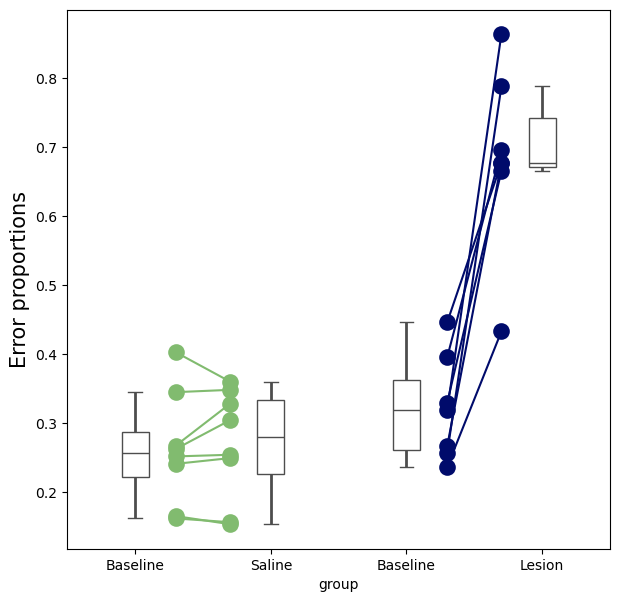

In [ ]:
data_df = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\lesion_data_df.csv")
data_df['error scores'] = data_df['error scores'].apply(parse_error_list)

control_mask = data_df.type.values == 'control'
c_early_learning_mask = data_df[control_mask].Group.values == 'Early Learning'
c_pre_mask = data_df[control_mask].Group.values == 'Pre Lesion'
c_post_mask = data_df[control_mask].Group.values == 'Post Lesion'

lesion_mask = data_df.type.values == 'lesion'
l_early_learning_mask = data_df[lesion_mask].Group.values == 'Early Learning'
l_pre_mask = data_df[lesion_mask].Group.values == 'Pre Lesion'
l_post_mask = data_df[lesion_mask].Group.values == 'Post Lesion'

c_all_errors =  [l.tolist() for l in data_df[control_mask][c_early_learning_mask]['error scores'].values],[l.tolist() for l in data_df[control_mask][c_pre_mask]['error scores'].values],[l.tolist() for l in data_df[control_mask][c_post_mask]['error scores'].values]
l_all_errors =  [l.tolist() for l in data_df[lesion_mask][l_early_learning_mask]['error scores'].values],[l.tolist() for l in data_df[lesion_mask][l_pre_mask]['error scores'].values],[l.tolist() for l in data_df[lesion_mask][l_post_mask]['error scores'].values]

c_errors = extract_errors_into_df(c_all_errors)
l_errors = extract_errors_into_df(l_all_errors)


buzz = 'error'

fig, ax = plt.subplots(1, 1,figsize=(7,7))

for i in range(len(c_all_errors[0])):
    ax.plot([0.3,0.7],[c_errors[buzz][1][i],c_errors[buzz][2][i]],'o-',color = "#81BB6F", alpha = 1, markersize = 12,markeredgewidth=0)
for i in range(len(l_all_errors[0])):
    ax.plot([2.3,2.7],[l_errors[buzz][1][i],l_errors[buzz][2][i]],'o-',color = "#000B6B",alpha = 1, markersize = 12,markeredgewidth=0)
    
scores = c_errors.error[1] + c_errors.error[2] + l_errors.error[1] + l_errors.error[2]
type_ = ['c_baseline']*len(c_errors.error[1]) + ['c_saline']*len(c_errors.error[2]) + ['l_Baseline']*len(l_errors.error[1]) + ['l_lesion']*len(l_errors.error[2])
plot_df = pd.DataFrame({'group': type_, 'error_rate': scores})

ax=sns.boxplot( y = 'error_rate', x = 'group', data = plot_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)
    
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(('Baseline', 'Saline', 'Baseline', 'Lesion'), fontsize = 10)
ax.set_ylabel('Error proportions',fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=10)


cb_mask = plot_df.group == 'c_baseline'
cl_mask = plot_df.group == 'c_saline'
lb_mask = plot_df.group == 'l_Baseline'
ll_mask = plot_df.group == 'l_lesion'

#stats
print('control baseline')
print(scipy.stats.normaltest(list(plot_df.error_rate[cb_mask])))
print('control saline')
print(scipy.stats.normaltest(list(plot_df.error_rate[cl_mask])))
if (scipy.stats.normaltest(list(plot_df.error_rate[cb_mask]))[-1] > 0.5) and (scipy.stats.normaltest(list(plot_df.error_rate[cl_mask]))[-1] > 0.5):
    print('data is normally distributed')
else:
    print('data is not normally distributed')
print(scipy.stats.ttest_rel(plot_df.error_rate[cb_mask],plot_df.error_rate[cl_mask]))
print('---------')


# STATS
control_delta = np.array(c_errors.error[1]) - np.array(c_errors.error[2])
lesion_delta =np.array(l_errors.error[1]) - np.array(l_errors.error[2])
# Compare groups on change scores
u_stat, p = mannwhitneyu(control_delta, lesion_delta)
print("Between-group change: Mann-Whitney p =", p)

u_stat = min(u_stat, len(control_delta)*len(lesion_delta) - u_stat)
def rank_biserial(u, n1, n2):
    return 1 - (2 * u) / (n1 * n2)
rbr = rank_biserial(u_stat, len(control_delta), len(lesion_delta))
print("Rank-biserial r:", rbr)



# figure F

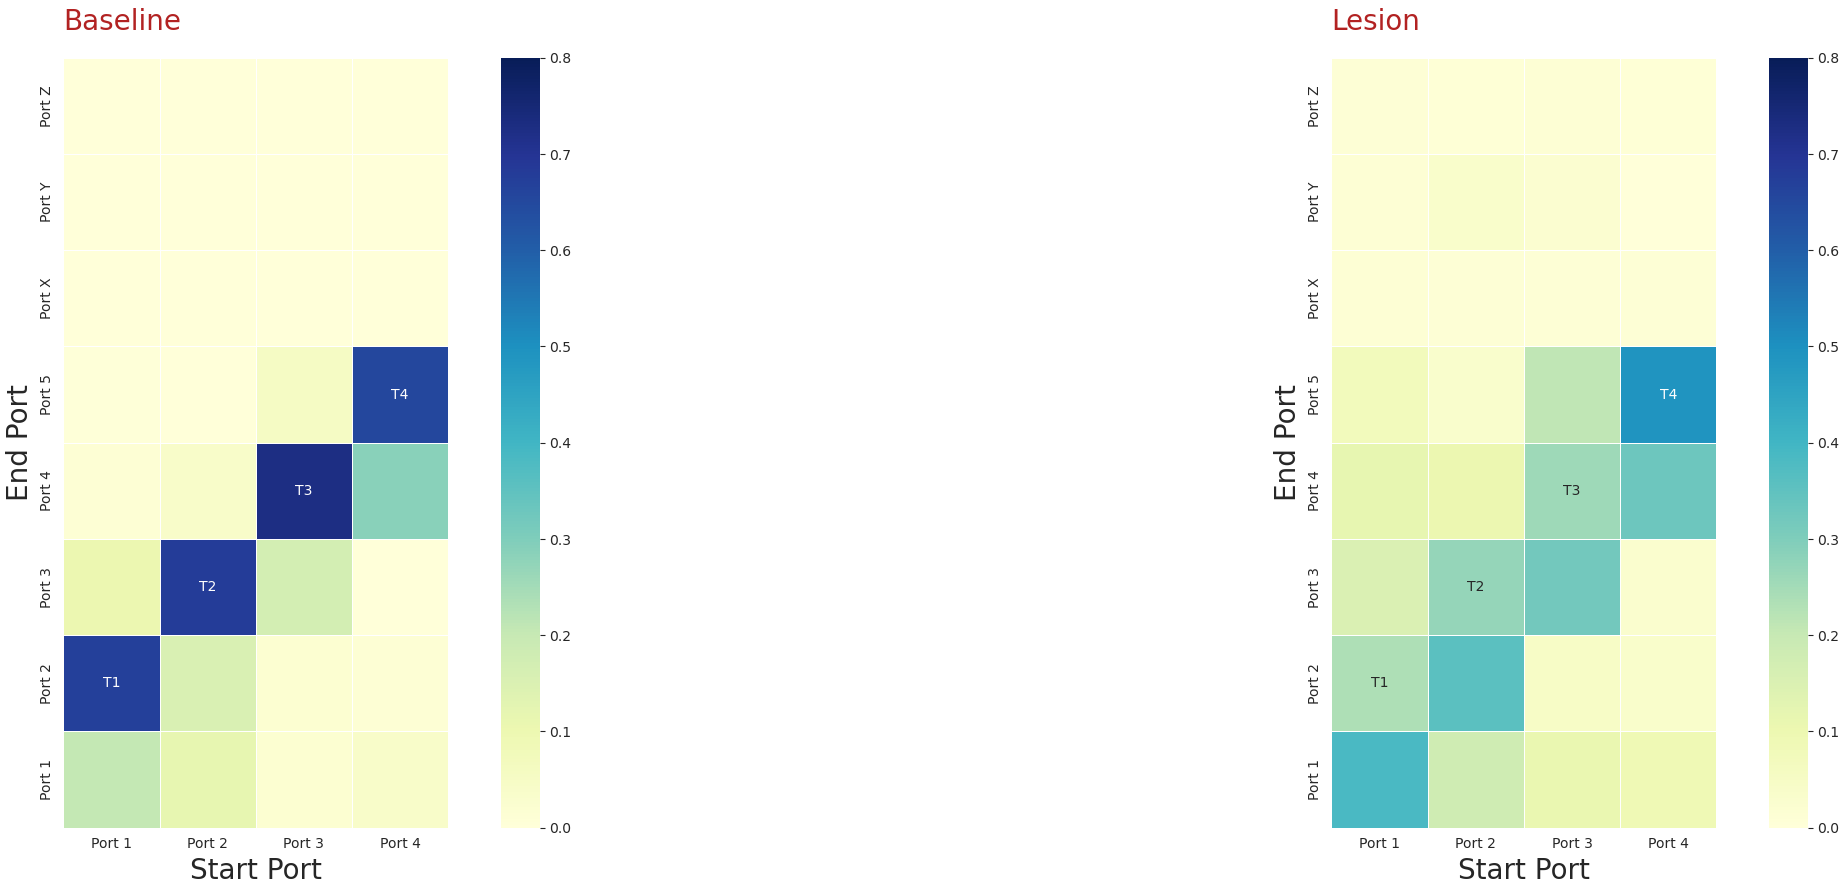

In [ ]:
data_df = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\lesion_data_df.csv")

control_mask = data_df.type.values == 'control'
c_early_learning_mask = data_df[control_mask].Group.values == 'Early Learning'
c_pre_mask = data_df[control_mask].Group.values == 'Pre Lesion'
c_post_mask = data_df[control_mask].Group.values == 'Post Lesion'

lesion_mask = data_df.type.values == 'lesion'
l_early_learning_mask = data_df[lesion_mask].Group.values == 'Early Learning'
l_pre_mask = data_df[lesion_mask].Group.values == 'Pre Lesion'
l_post_mask = data_df[lesion_mask].Group.values == 'Post Lesion'

c_all_tmatrix = [data_df[control_mask][c_early_learning_mask].transition_matrix.values,data_df[control_mask][c_pre_mask].transition_matrix.values,data_df[control_mask][c_post_mask].transition_matrix.values]
l_all_tmatrix = [data_df[lesion_mask][l_early_learning_mask].transition_matrix.values,data_df[lesion_mask][l_pre_mask].transition_matrix.values,data_df[lesion_mask][l_post_mask].transition_matrix.values]


c_all_tmatrix_ = []
for arr in c_all_tmatrix:
    parsed = [ast.literal_eval(item) for item in arr]   # convert each string to list
    c_all_tmatrix_.append(parsed)
l_all_tmatrix_ = []
for arr in l_all_tmatrix:
    parsed = [ast.literal_eval(item) for item in arr]   # convert each string to list
    l_all_tmatrix_.append(parsed)


C_group_means = average_across_animals_transition_matrix(c_all_tmatrix_)
L_group_means = average_across_animals_transition_matrix(l_all_tmatrix_)


######normalise data by column:
c_means_norm = normalise_transition_matrix_means(C_group_means) 
l_means_norm = normalise_transition_matrix_means(L_group_means) 

c_max = np.max(c_means_norm)
l_max = np.max(l_means_norm)

d1 = np.array(c_means_norm[1]) - np.array(c_means_norm[2])
d2 = np.array(l_means_norm[1]) - np.array(l_means_norm[2])
d1_list = [list(d1.tolist())]
d2_list = [list(d2.tolist())]

normalised_means = c_means_norm + l_means_norm

## create mask and labels
x_axis_labels = ['Port 1','Port 2','Port 3','Port 4'] # labels for x-axis
y_axis_labels = ['Port Z','Port Y','Port X','Port 5','Port 4','Port 3','Port 2','Port 1'] # labels for y-axis
labels =  np.array([['','','',''],
                    ['','','',''],
                    ['','','',''],
                    ['','','','T4'],
                    ['','','T3',''],
                    ['','T2','',''],
                    ['T1','','',''],
                    ['','','','']])

mask = np.zeros_like(normalised_means[4])

#plot:
title = ['Baseline','Lesion']
with sns.axes_style("white"):
    nrow = 1 
    ncol = 2
    counter = 0
    fig, axs = plt.subplots(nrow, ncol,figsize=(30, 10))
    for ind, ax in enumerate(fig.axes):
        if counter < 3:
            maximum = c_max
        else:
            maximum = l_max
        h1 = sns.heatmap(normalised_means[4::][counter],xticklabels=x_axis_labels, yticklabels=y_axis_labels, 
                        linewidths=.5, mask=mask, square=True,cmap="YlGnBu",annot = labels,fmt = '',ax=ax,cbar_kws = dict(use_gridspec=False,location="right"), vmin = 0,vmax = 0.8)

        ax.set_ylabel('End Port',size = 20)
        ax.set_xlabel('Start Port',size = 20)
        ax.set_title(title[counter], loc = 'left',pad = 20,fontsize = 20,color = 'firebrick')
        counter = counter + 1
    

# figure H

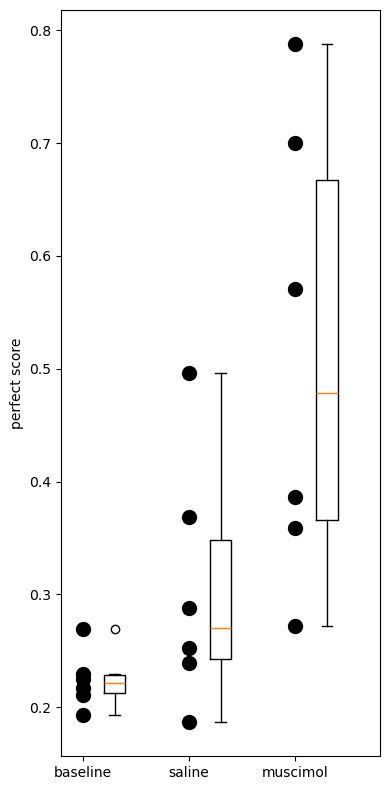

In [2]:
muscimol_error_rate_df = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\muscimol_error_rate_df.csv")

# --- Plot ---
plt.figure(figsize=(4,8))
groups = ["baseline", "saline", "muscimol"]
xpos = np.arange(len(groups))

# Scatter + jitter
for i, g in enumerate(groups):
    y = muscimol_error_rate_df[muscimol_error_rate_df["experiment"] == g]["perfect score"]
    plt.plot(np.full(len(y), xpos[i]), y, 'o',markersize = 10, color = 'k')

# Boxplots
plt.boxplot(
    [muscimol_error_rate_df[muscimol_error_rate_df["experiment"] == g]["perfect score"] for g in groups],
    positions=xpos+0.3,
    widths=0.2
)

plt.xticks(xpos, groups)
plt.ylabel("perfect score")
plt.tight_layout()
plt.show()


# figure K 

In [6]:
pl_data.training_levels[0]

'[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

 37%|███▋      | 3725/10000 [00:06<00:11, 543.65it/s]


KeyboardInterrupt: 

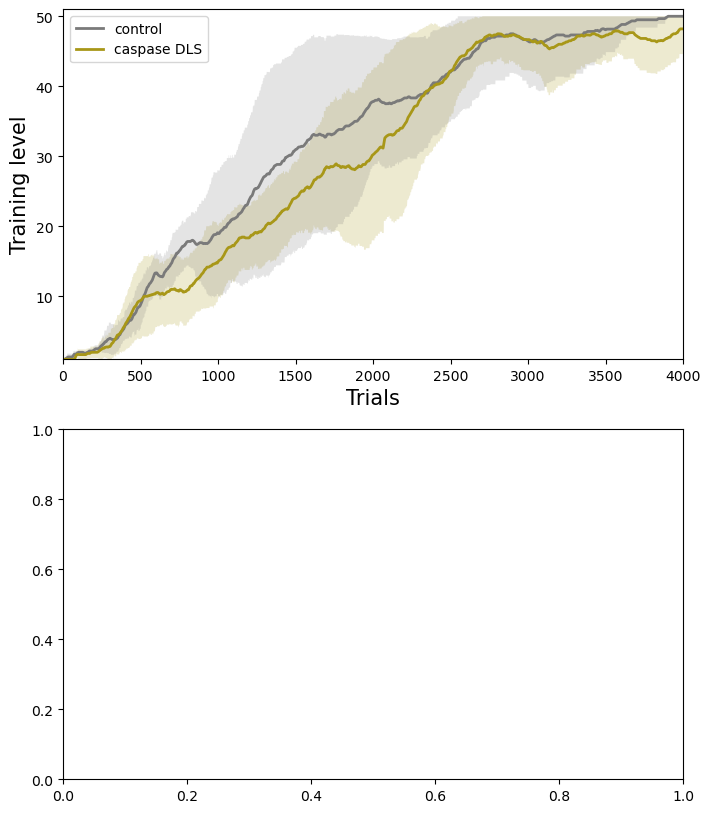

In [3]:
# 1. LOAD DATA - Read CSV
pl_data = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f1\DLS_DMS_lesion_learning_curves.csv")

# Masks
DLS_mask = pl_data.type == 'DMS'

# Extract data
categories = pl_data.catagory[DLS_mask].values
animals = pl_data.animal[DLS_mask].values
t_levels = parse_training_levels(pl_data.training_levels[DLS_mask].values)

# Calculate mean and std for lesion and control groups
lesion_mask = categories == 'lesion'
lesion_MeanLearningCurve, lesion_std = calculate_mean_std(t_levels, lesion_mask)

control_mask = categories == 'control'
control_MeanLearningCurve, control_std = calculate_mean_std(t_levels, control_mask)

# Plot
%matplotlib inline
window = 10
xlim = 4000

fig, [ax,ax2] = plt.subplots(2, 1, figsize=(8, 10))
ax.set_xlim([0, xlim])
ax.set_ylim([1, 51])

ax.plot(convolve_movmean(control_MeanLearningCurve[:xlim], window), '-', color="#7A7A7A", linewidth=2,label = 'control')
ax.plot(convolve_movmean(lesion_MeanLearningCurve[:xlim], window), '-', color='#A89718', linewidth=2,label = 'caspase DLS')

ax.set_xlabel('Trials', fontsize=15)
ax.set_ylabel('Training level', fontsize=15)

fill_between_mean_std(ax, lesion_MeanLearningCurve, lesion_std, "#A89718",xlim)
fill_between_mean_std(ax, control_MeanLearningCurve, control_std, "#7A7A7A",xlim)
ax.legend()

############ PLOT 2 - obsevred vs shuffle #########

# Set cut-off for number of trials to consider
cut = 4000
# Initialize lists to store data
new, group, cum_trials, animalid = [], [], [], []
# Process each item in t_levels
for index, item in enumerate(t_levels):
    new += item[0:cut]  # Append the first 'cut' elements of the current item
    group += cut * ['lesion' if index < len(t_levels) / 2 else 'control']  # Assign group
    animalid += [animals[index]] * cut  # Append animal ID
    cum_trials += list(np.linspace(1, cut, cut))  # Generate cumulative trial numbers
# Create DataFrame with collected data
min_len = min(len(cum_trials), len(new), len(group), len(animalid))

cum_trials = cum_trials[:min_len]
new        = new[:min_len]
group      = group[:min_len]
animalid   = animalid[:min_len]

df = pd.DataFrame({
    'CumTrials': cum_trials,
    'Level': new,
    'Group': group,
    'ID': animalid
})

# Define function to generate experimental group labels
def generate_eg(list_size, prob, hue_order):
    return [hue_order[0] if random.random() < prob else hue_order[1] for _ in range(list_size)]

# define a 100-trial window to bin the data
XBIN = 100
# Bin trial indices
df["TrialIndexBinned"] = (df.CumTrials.values // XBIN) * XBIN + XBIN / 2
# Group by 'ID', 'Group', 'TrialIndexBinned' and calculate mean
df_bintr = df.groupby(['ID', 'Group', 'TrialIndexBinned']).mean().reset_index()
df_bintr['Performance'] = df_bintr.Level
hue_order = ['control', 'lesion']
# Calculate performance difference between groups
perdif_df = df_bintr[df_bintr.Group == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
            df_bintr[df_bintr.Group == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']
# Select necessary columns
df_colsel = df_bintr[['ID', 'Group', 'TrialIndexBinned', 'Performance']].copy()
# Calculate probability for experimental group
exp_gr = [df_colsel[df_colsel.ID == x].Group.unique()[0] for x in df_colsel.ID.unique()]
cb_prob = sum([x == hue_order[0] for x in exp_gr]) / len(exp_gr)

# Seed for reproducibility
np.random.seed(124321)
# Shuffle results
shuff_res = []
# Shuffle and compute performance differences
NSH = 10000
for _ in tqdm(range(NSH)):
    exp_grs = generate_eg(len(exp_gr), cb_prob,hue_order)
    egs_dict = dict(zip(df_colsel.ID.unique(), exp_grs))
    df_colsel['egs'] = df_colsel.ID.map(egs_dict)
    diff = df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
           df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']
    shuff_res.append(diff)
shrdf = pd.concat(shuff_res)

# Calculate real data performance difference
real_data = df_colsel[df_colsel.Group == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
            df_colsel[df_colsel.Group == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']
real_data *= -1

# Plot results
pos_ci = shrdf.groupby('TrialIndexBinned').quantile(.95)
neg_ci = shrdf.groupby('TrialIndexBinned').quantile(.05)

ax2.axhline(0, ls='dotted', alpha=0.4, color='k')
ax2.plot(real_data, color='#A89718', label='observed data')
ax2.plot(pos_ci, linestyle='--', color='#7A7A7A', label='95% ci')
ax2.plot(neg_ci, linestyle='--', color='#7A7A7A')

x = pos_ci.reset_index().TrialIndexBinned
y1 = neg_ci.reset_index().Performance
y2 = real_data.reset_index().Performance

ax2.fill_between(x, y1, y2, where=y2 <= y1, facecolor='#A89718', alpha=.3, interpolate=True)
ax2.set_ylabel('Performance difference (levels)')
ax2.set_xlabel('trial number')
ax2.legend(loc=(0.75, 0.05), frameon=False)
ax2 = plt.gca()
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlim((0, 4000))

# figure L 
see above (plotted with figure D)

# figure M

(0.0, 1000.0)

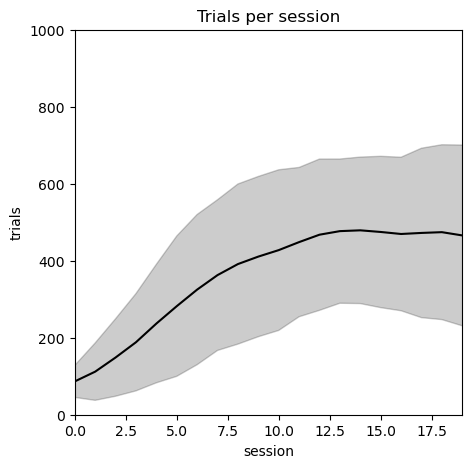

In [125]:
df = pd.read_csv(r'C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f1\learning_curves.csv')



AA_trials_per_session = [ast.literal_eval(item) for item in df.trials_per_session.values]

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
lesion_data = []
control_data = []

smoothing_window = 6
# Calculate and plot the mean trials
_mean = []
std_  = []
for item in conactinate_nth_items(AA_trials_per_session)[0:40]:
    _mean.append(np.mean(item))
    std_.append(np.std(item))
ax.plot(convolve_movmean(_mean,smoothing_window), color='k')

# Plot the standard deviation
ax.fill_between(range(len(_mean)), convolve_movmean(np.array(_mean) - np.array(std_),smoothing_window), convolve_movmean(np.array(_mean) + np.array(std_),smoothing_window), color='k', alpha=0.2)

# Set plot labels and limits
ax.set_title('Trials per session')
ax.set_xlabel('session')
ax.set_ylabel('trials')
ax.set_xlim(0, 19)
ax.set_ylim(0, 1000)

# figure N

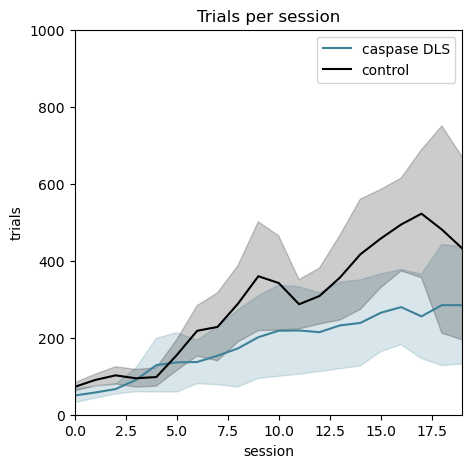

In [87]:
data = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\trials_per_session_dls.csv")
dls_lesion_tps = [ast.literal_eval(item) for item in data[data.group == 'dls_lesion'].trials_per_session.values]
control_lesion_tps = [ast.literal_eval(item) for item in data[data.group == 'control'].trials_per_session.values]

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
smoothing_window = 2
# Calculate and plot the mean trials
_mean = []
std_  = []
for item in conactinate_nth_items(dls_lesion_tps):
    _mean.append(np.mean(item))
    std_.append(np.std(item))
ax.plot(convolve_movmean(_mean,smoothing_window), color='#3D8198',label = 'caspase DLS')
# Plot the standard deviation
ax.fill_between(range(len(_mean)), convolve_movmean(np.array(_mean) - np.array(std_),smoothing_window), convolve_movmean(np.array(_mean) + np.array(std_),smoothing_window), color="#3D8198", alpha=0.2)

# Calculate and plot the mean trials
_mean = []
std_  = []
for item in conactinate_nth_items(control_lesion_tps):
    _mean.append(np.mean(item))
    std_.append(np.std(item))
ax.plot(convolve_movmean(_mean,smoothing_window), color='k',label = 'control')
# Plot the standard deviation
ax.fill_between(range(len(_mean)), convolve_movmean(np.array(_mean) - np.array(std_),smoothing_window), convolve_movmean(np.array(_mean) + np.array(std_),smoothing_window), color='k', alpha=0.2)

# Set plot labels and limits
ax.set_title('Trials per session')
ax.set_xlabel('session')
ax.set_ylabel('trials')
ax.set_xlim(0, 19)
ax.set_ylim(0, 1000)

ax.legend()

# figure O

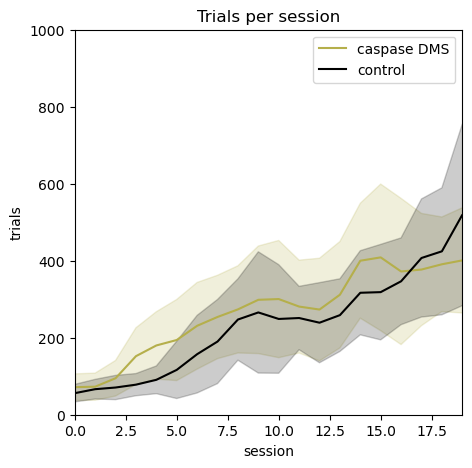

In [86]:
data = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\trials_per_session_dms.csv")
dms_lesion_tps = [ast.literal_eval(item) for item in data[data.group == 'dms_lesion'].trials_per_session.values]
control_lesion_tps = [ast.literal_eval(item) for item in data[data.group == 'control'].trials_per_session.values]

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
smoothing_window = 2
# Calculate and plot the mean trials
_mean = []
std_  = []
for item in conactinate_nth_items(dms_lesion_tps):
    _mean.append(np.mean(item))
    std_.append(np.std(item))
ax.plot(convolve_movmean(_mean,smoothing_window), color="#B5AF4B",label = 'caspase DMS')
# Plot the standard deviation
ax.fill_between(range(len(_mean)), convolve_movmean(np.array(_mean) - np.array(std_),smoothing_window), convolve_movmean(np.array(_mean) + np.array(std_),smoothing_window), color="#B5AF4B", alpha=0.2)

# Calculate and plot the mean trials
_mean = []
std_  = []
for item in conactinate_nth_items(control_lesion_tps):
    _mean.append(np.mean(item))
    std_.append(np.std(item))
ax.plot(convolve_movmean(_mean,smoothing_window), color='k',label = 'control')
# Plot the standard deviation
ax.fill_between(range(len(_mean)), convolve_movmean(np.array(_mean) - np.array(std_),smoothing_window), convolve_movmean(np.array(_mean) + np.array(std_),smoothing_window), color='k', alpha=0.2)

# Set plot labels and limits
ax.set_title('Trials per session')
ax.set_xlabel('session')
ax.set_ylabel('trials')
ax.set_xlim(0, 19)
ax.set_ylim(0, 1000)

ax.legend()

# figure P

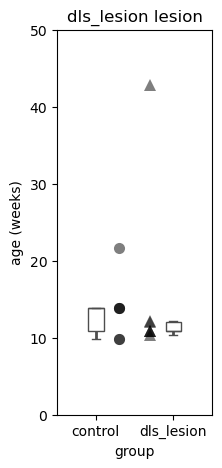

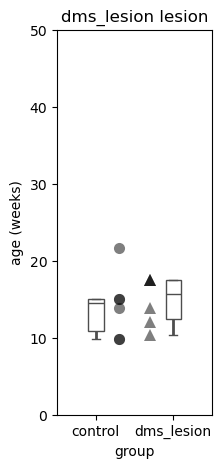

In [ ]:
dms_lesion_data= pd.read_csv(r'C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\DMS_lesion_age_data.csv')
dls_lesion_data = pd.read_csv(r'C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\DLS_lesion_age_data.csv')

def plot_lesion_data(lesion_data, lesion_name):
    var_str = f'{lesion_name} lesion'

    plt_df = lesion_data
    cont = plt_df.age_weeks[plt_df.group == 'control'].values
    lesi = plt_df.age_weeks[plt_df.group == lesion_name].values

    fig, ax = plt.subplots(1, 1, figsize=(2, 5))
    for i in range(len(cont)):
        ax.plot([0.3], cont[i], '--o', color='k', alpha=0.5, markeredgewidth=0, markersize=8)
    for i in range(len(lesi)):
        ax.plot([0.7], lesi[i], '--^', color='k', alpha=0.5, markeredgewidth=0, markersize=8)

    dat = list(cont) + list(lesi)
    groups = ['control'] * len(cont) + [lesion_name] * len(lesi)
    plt_df = pd.DataFrame({'group': groups, 'age (weeks)': dat})
    ax = sns.boxplot(y='age (weeks)', x='group', data=plt_df, color='blue', width=.2, zorder=10,
                     showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                     showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                     saturation=1, orient='v')

    ax.set_title(var_str)
    
    ax.set_ylim(0,50)


plot_lesion_data(dls_lesion_data, 'dls_lesion')
# SaveFig('dls-control-ages.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\age_analysis\\")

plot_lesion_data(dms_lesion_data, 'dms_lesion')
# SaveFig('dms-control-ages.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\age_analysis\\")


In [ ]:

# data_df = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\lesion_data_df.csv")



# df = 

# data = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\trials_per_session_dls.csv")
# data = pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\trials_per_session_dms.csv")

# dms_lesion_data= pd.read_csv(r'C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\DMS_lesion_age_data.csv')
# dls_lesion_data = pd.read_csv(r'C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\DLS_lesion_age_data.csv')


my_dict = {
'DLS_DMS_lesion_learning_curves_df':pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f1\DLS_DMS_lesion_learning_curves.csv"),
'lesion_data_df' : pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\lesion_data_df.csv"),
'muscimol_error_rate_df' : pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\muscimol_error_rate_df.csv"),
'example_learning_curves_df': pd.read_csv(r'C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\f1\learning_curves.csv'),
'trials_per_session_dls_df' : pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\trials_per_session_dls.csv"),
'trials_per_session_dms_df' : pd.read_csv(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\trials_per_session_dms.csv"),
'dms_lesion_age_df': pd.read_csv(r'C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\DMS_lesion_age_data.csv'),
'dls_lesion_age_df': pd.read_csv(r'C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2\DLS_lesion_age_data.csv'),
}


In [5]:

muscimol_error_rate_df.reset_index()

,index,Unnamed: 0,perfect score,experiment
0,0,0,0.192789,baseline
1,1,1,0.269527,baseline
2,2,2,0.229571,baseline
3,3,3,0.210489,baseline
4,4,4,0.217292,baseline
5,5,5,0.225249,baseline
6,6,6,0.287842,saline
7,7,7,0.252304,saline
8,8,8,0.368919,saline
9,9,9,0.239155,saline


In [ ]:
save_h5(my_dict,r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED2_data.h5")

TypeError: isinstance() arg 2 must be a type, a tuple of types, or a union

In [3]:
import h5py
def save_h5(data_dict, filename):
    """
    Save a dictionary to HDF5, handling:
    - Nested dictionaries
    - DataFrames (numeric, string, mixed)
    - Lists (including jagged)
    - NumPy arrays and scalars
    All object/string data is stored as UTF-8 variable-length strings for seamless loading.
    """
    def save_item(group, key, item):
        if isinstance(item, dict):
            subgroup = group.create_group(key)
            for subkey, subitem in item.items():
                save_item(subgroup, subkey, subitem)

        elif isinstance(item, pd.DataFrame):
            subgroup = group.create_group(key)
            # Save column names as UTF-8 strings
            subgroup.attrs['columns'] = np.array(item.columns, dtype='S')
            dt = h5py.string_dtype(encoding='utf-8')
            # Convert all cells to strings for HDF5, including numeric values
            data_as_strings = np.array([[str(cell) for cell in row] for row in item.values], dtype=object)
            subgroup.create_dataset('data', data=data_as_strings, dtype=dt)

        elif isinstance(item, list):
            dt = h5py.string_dtype(encoding='utf-8')
            # Convert list elements to strings for storage (works for mixed/jagged lists)
            arr = np.array([str(x) for x in item], dtype=object)
            group.create_dataset(key, data=arr, dtype=dt)

        elif isinstance(item, np.ndarray):
            if item.dtype == object:
                dt = h5py.string_dtype(encoding='utf-8')
                arr = np.array([str(x) for x in item.flat], dtype=object).reshape(item.shape)
                group.create_dataset(key, data=arr, dtype=dt)
            else:
                group.create_dataset(key, data=item)

        else:
            # Scalars
            group.create_dataset(key, data=item)

    with h5py.File(filename, "w") as f:
        for key, value in data_dict.items():
            save_item(f, key, value)